In [124]:
import geopandas as gpd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ee 
import geemap.eefolium as geemap
import os
#import geemap, ee 
# folium for datapane; otherwise call regular geemap as it runs with better functionality (ipyleaflet)

In [125]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [126]:
# Set path to wd
path = os.path.join("/","Users","MT","Nextcloud","Projects","GOV-BGD20GIZ7333_CRISC_AI")

In [127]:
# helper function: lookup shp index by city/levell geodataframe format, ee object construct
def shp_to_ee_fmt(city, level):
    dic = {'Satkhira':{2:56,3:469,4:4307},'Sirajganj':{2:59,3:496,4:4493}}
    ind = dic[city][level]
    shp_path = os.path.join(path,"CRISC_RS","bgd_adm_bbs_20201113_SHP","bgd_admbnda_adm"+str(level)+"_bbs_20201113.shp")
    gdf = gpd.read_file(shp_path, crs='EPSG:4326')
    x = gdf.iloc[ind:ind+1,:]
    data = json.loads(x.to_json())
    return data['features'][0]['geometry']['coordinates']

# Source shp: https://data.humdata.org/dataset/administrative-boundaries-of-bangladesh-as-of-2015

# Histogram function
def histo(dist, band, bins, city, level):
    aoi = ee.Geometry.MultiPolygon(shp_to_ee_fmt(city = city, level = level))
    arr = np.array(dist.sampleRectangle(region=aoi).get(band).getInfo())
    data = arr.flatten()
    fig, ax = plt.subplots(figsize=(15,5))
    sns.histplot(data, bins=bins,ax=ax)
    plt.title('Distribution: '+city, fontsize=20)

In [109]:
viirs = ee.Image(ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate("2019-01-01","2019-12-31").median().select('avg_rad'))

In [110]:
srtm = ee.Image("CGIAR/SRTM90_V4").select('elevation')
srtmVis = {'min':-1, 'max':14,'palette':['#f7fcfd','#e5f5f9','#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#005824']}

In [111]:
water = ee.Image("JRC/GSW1_3/GlobalSurfaceWater").select('occurrence')
waterVis= {"min":0, "max":50,"palette":['lightblue', 'blue'], "bands":"occurrence"}

In [112]:
ghslSet = ee.ImageCollection('JRC/GHSL/P2016/SMOD_POP_GLOBE_V1').filter(ee.Filter.date('2015-01-01', '2015-12-31')).select('smod_code').median();
ghslSetVis= {"min":0.0, "max":3.0,"palette":['000000', '448564', '70daa4', 'ffffff']}

In [113]:
ghslPop = ee.ImageCollection("JRC/GHSL/P2016/POP_GPW_GLOBE_V1").filter(ee.Filter.date('2015-01-01', '2015-12-31')).select('population_count').median();
ghslPopVis= {"min":0.0, "max":5000.0,"palette":['000000', '448564', '70daa4', 'ffffff']}

In [114]:
# Flowminder Poverty Predictions based on mobile data (https://royalsocietypublishing.org/doi/full/10.1098/rsif.2016.0690)
# 2011 estimates of mean DHS wealth index score per grid square 
pov_wi = ee.Image('users/marktyrrell111/bgd2011wipov')
# 2013 estimates of income in USD per grid square 
pov_inc = ee.Image('users/marktyrrell111/bgd2013incpov')
# 013 estimates of mean likelihood of living in poverty per grid square, as defined by $2.50 a day poverty line
pov_prop = ee.Image('users/marktyrrell111/bgd2013ppipov')

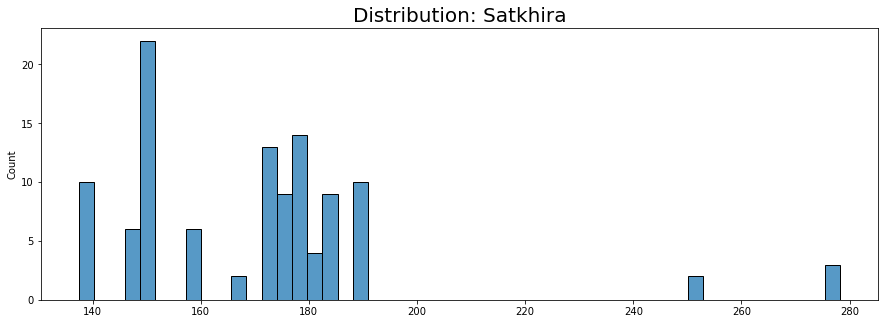

In [97]:
histo(dist = pov_inc, band = 'b1', bins = 50, city = 'Satkhira', level = 4 )

In [128]:
#AOI: Satkhira District (Khulna Division)
aoi = ee.Geometry.MultiPolygon(shp_to_ee_fmt(city = 'Satkhira', level = 3))

# initialize the map
map1 = geemap.Map()
map1.centerObject(aoi, 13)
map1.addLayer(viirs.clip(aoi), {}, "VIIRS-DNB Nightlights", opacity=0.1)
map1.addLayer(ghslSet.clip(aoi), ghslSetVis, 'GHSL Degree of Urbanization', opacity=0.5)
map1.addLayer(ghslPop.clip(aoi), ghslPopVis, 'GHSL Population', opacity=0.5)
map1.addLayer(srtm.clip(aoi), {'min':-1, 'max':14}, 'SRTM Elevation', opacity = 0.6)
map1.addLayer(water.clip(aoi), waterVis, 'JRC Water Prevalence', opacity = 0.6)
map1.addLayer(pov_inc.clip(aoi), {'min':130, 'max':200, "palette":['red', 'yellow']}, "BD Poverty: Income", opacity=0.6)
map1.addLayer(pov_wi.clip(aoi), {'min':-0.2, 'max':1.2, "palette":['red', 'yellow']}, "BD cPoverty: Wealth Index", opacity=0.6)
map1.addLayerControl()
map1

## Layers
* Google maps (comparison with OSM)
* VIIRS Nightlights Average Radiance 2019 median (approx. 500m resolution; B&W scale from dark to light indicating higher luminance)
* GHSL Settlements Classification 2015 (1Km resolution)
    - Black: Inhabited areas
    - Dark Green: RUR (rural grid cells)
    - Light Green: LDC (low density clusters)
    - White: HDC (high density clusters)
*	GHSL Population Estimations 2015 (250m resolution with scale from dark to light colours indicating higher population)
*	SRTM Elevation (90m resolution; B&W scale from dark to light indicating higher elevation values)
*	JRC Water surface levels: Occurrence 1984-1999, 2000-2020 (30m resolution; scale from light to dark blue indicating higher water prevalence; no colour = water never detected)
* Flowminder Bangladesh poverty estimates (2011-2013) by 1km grid (https://royalsocietypublishing.org/doi/full/10.1098/rsif.2016.0690)


In [129]:
import datapane as dp
dp.login(token='2b8de896fc86c1d7b568474c553dca773dc3c606')

Connected successfully to https://datapane.com as mtyrrell


'mtyrrell'

In [131]:
map1.publish(name='Satkhira Municipal: Multi Layer', description='SatKhira GAUL Level 3 with VIIRS, GHSL, Topo, Water & Poverty', visibility='PUBLIC')

Publishing document and associated data - *please wait...*

Your report doesn't contain any text - did you know you can add text to your report from your browser once published?

Your report only contains a single element - did you know you can add multiple plots and tables to a report, add text to it and export directly to Medium once published?

Report successfully published at https://datapane.com/u/mtyrrell/reports/satkhira-municipal-multi-layer/ - you can edit and add additional text online

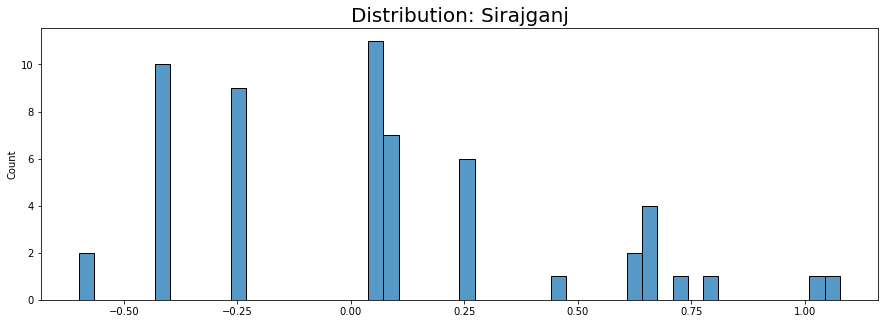

In [133]:
histo(dist = pov_wi, band = 'b1', bins = 50, city = 'Sirajganj', level = 4 )

In [134]:
#AOI: Satkhira District (Khulna Division)
aoi = ee.Geometry.MultiPolygon(shp_to_ee_fmt(city = 'Sirajganj', level = 3))

# initialize the map
map2 = geemap.Map()
map2.centerObject(aoi, 12)
map2.addLayer(viirs.clip(aoi), {}, "VIIRS-DNB Nightlights", opacity=0.5)
map2.addLayer(ghslSet.clip(aoi), ghslSetVis, 'GHSL Degree of Urbanization', opacity=0.5)
map2.addLayer(ghslPop.clip(aoi), ghslPopVis, 'GHSL Population', opacity=0.5)
map2.addLayer(srtm.clip(aoi), {'min':5, 'max':25}, 'SRTM Elevation', opacity = 0.6)
map2.addLayer(water.clip(aoi), waterVis, 'JRC Water Prevalence', opacity = 0.6)
map2.addLayer(pov_inc.clip(aoi), {'min':120, 'max':210, "palette":['red', 'yellow']}, "BD Poverty: Income", opacity=0.6)
map2.addLayer(pov_wi.clip(aoi), {'min':-0.75, 'max':1.1, "palette":['red', 'yellow']}, "BD cPoverty: Wealth Index", opacity=0.6)
map2.addLayerControl()
map2

In [135]:
map2.publish(name='Sirajganj Municipal: Multi Layer', description='Sirajganj GAUL Level 3 with VIIRS, GHSL, Topo, Water & Poverty', visibility='PUBLIC')

Publishing document and associated data - *please wait...*

Your report doesn't contain any text - did you know you can add text to your report from your browser once published?

Your report only contains a single element - did you know you can add multiple plots and tables to a report, add text to it and export directly to Medium once published?

Report successfully published at https://datapane.com/u/mtyrrell/reports/sirajganj-municipal-multi-layer/ - you can edit and add additional text online